In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import shutil

plt.ion()

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
}

data_dir = '/home/oyashi/datasets/unesco/'
dsets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val','test']
}

dset_loaders = {
    x: torch.utils.data.DataLoader(dsets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val','test']
}

dset_sizes = {
    x: len(dsets[x])
    for x in ['train', 'val','test']
}

dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

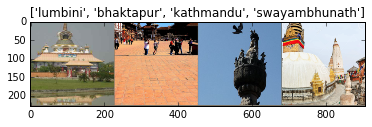

In [4]:
%matplotlib inline
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [dset_classes[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer,epoch)
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _,pred = torch.max(outputs.data,1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(pred == labels.data)
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f}'.format(best_acc))
    return best_model

In [6]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return optimizer

In [18]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,10)

if use_gpu:
    model_conv = model_conv.cuda()
    
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/oyashi/.torch/models/resnet18-5c106cde.pth
100.0%


In [9]:
model_conv = train_model(model_conv, criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

torch.save(model_conv.state_dict(),'unesco10_pytorch_model')

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.4949 Acc: 0.3205
val Loss: 0.2420 Acc: 0.7434

Epoch 1/24
----------
train Loss: 0.3854 Acc: 0.4823
val Loss: 0.2151 Acc: 0.7460

Epoch 2/24
----------
train Loss: 0.3299 Acc: 0.5592
val Loss: 0.2512 Acc: 0.7143

Epoch 3/24
----------
train Loss: 0.3192 Acc: 0.5693
val Loss: 0.1967 Acc: 0.7513

Epoch 4/24
----------
train Loss: 0.3229 Acc: 0.5743
val Loss: 0.1826 Acc: 0.7804

Epoch 5/24
----------
train Loss: 0.3109 Acc: 0.5956
val Loss: 0.1689 Acc: 0.8042

Epoch 6/24
----------
train Loss: 0.2940 Acc: 0.5956
val Loss: 0.1640 Acc: 0.8280

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.2548 Acc: 0.6795
val Loss: 0.1616 Acc: 0.8413

Epoch 8/24
----------
train Loss: 0.2377 Acc: 0.6855
val Loss: 0.1567 Acc: 0.8333

Epoch 9/24
----------
train Loss: 0.2526 Acc: 0.6795
val Loss: 0.1560 Acc: 0.8175

Epoch 10/24
----------
train Loss: 0.2505 Acc: 0.6633
val Loss: 0.1604 Acc: 0.8360

Epoch 11/24
----------
train Loss: 0.2486 Acc: 

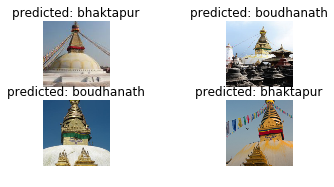

In [21]:
visualize_model(model_conv)